# Project 4 - QR Code Reader

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">4 hours</span>
* 2. Part B: <span style="color:red;">1 hour</span>
* 3. Part C: <span style="color:red;">30 minutes</span>
* 4. Tests: <span style="color:red;">2 hours</span>
* 5. Challenge 1: <span style="color:red;">1 hour</span>
* 6. Challenge 2: <span style="color:red;">15 minutes</span>
* 7. Write-up: <span style="color:red;">15 minutes</span>

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

For this lab, we will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

In [58]:
 %pylab inline

Populating the interactive namespace from numpy and matplotlib


In [59]:
import cv2
import numpy as np
import random
import copy
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # notebook compatible
from PIL import Image

plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': rcParams['axes.titlesize'],
                                 'fontweight' : rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])
    
    
def color2gray(image):
    result = image[:, :, 0] * 0.299 + image[:, :, 1] * 0.587 + image[:, :, 2] * 0.114
    return result


def rgb(img):
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return RGB_img

### Part A: Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:20%;text-align:center;"><img src="Images/finder_pattern.jpg" width=100%></div>

Preprocess your image by thresholding to black and white. Scan across rows of the image, marking locations that have the 1:1:3:1:1 ratio (note: this is most easily done by keeping multiple counters for black and white pixels).

<div style="width:20%;text-align:center;"><img src="Images/first_scan.jpg" width=100%></div>

Once you have candidate locations, verify the locations by also scanning vertically, diagonally and in other directions. Also complete a non maximal suppression to get your final three candidate points.

<div style="width:20%;text-align:center;"><img src="Images/candidates.JPG" width=100%></div>

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


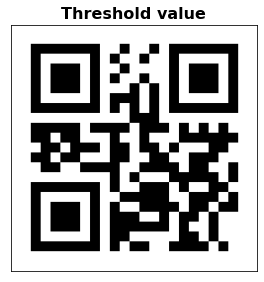

In [60]:
def threshold_to_bw(img, threshold=130):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#     img = cv2.filter2D(img, -1, kernel)
#     img = cv2.medianBlur(img, 7)
#     img = cv2.GaussianBlur(img,(3,3),0)
    if len(img.shape) > 2:
        img = color2gray(img)
    img = (img > threshold).astype(float)
    return img


img = threshold_to_bw(rgb(cv2.imread('QR_codes/test1.png')))
plt.subplot(131)
plt.imshow(img, cmap='gray')
just_title("Threshold value")
print(img)

In [61]:
def get_counts_bw(img, axis=(0, 1)) -> list:
    img_results = []
    for row_pos in range(img.shape[axis[0]]):
        row_counter = []
        cur_type = img[row_pos, 0] if not axis[0] else img[0, row_pos]
        cur_count = 0
        for col_pos in range(img.shape[axis[1]]):
            next_type = img[row_pos, col_pos] if not axis[0] else img[col_pos, row_pos]
            if cur_type != next_type:
                row_counter.append(cur_count)
                cur_count = 1
                cur_type = next_type
            else:
                cur_count += 1
        row_counter.append(cur_count)
        img_results.append(row_counter)
    return img_results

# image = cv2.imread("QR_codes/test2.png", cv2.IMREAD_GRAYSCALE)
# counts = get_counts_bw(threshold_to_bw(image), axis=(0, 1))
# for i, count in enumerate(counts):
#     print(i, count)

In [62]:
from collections import defaultdict
import math
from scipy import ndimage, misc


def get_potential_squares(img: np.array, values: list, is_row: bool = True) -> list:
#     print(values[:5])
    gold_ratio = np.array([1, 1, 3, 1, 1])
    potential_matches = []
    for row_idx, value in enumerate(values):
        np_val = np.array(copy.deepcopy(value))
        equals = np.where(np.equal(np_val[:-1], np_val[1:]))[0].tolist()
#         print(np_val)
        if len(equals):
            for start_idx in equals:
                col_pos = np_val[:start_idx].sum()
                start_color = img[row_idx, max(0, col_pos + 1)] if is_row else img[max(0, col_pos + 1), row_idx]
                ratio = copy.deepcopy(np_val[start_idx:start_idx+5]) / copy.deepcopy(np_val[start_idx])
#                 close_ratio = np.round(ratio)
                # black is 0
#                 print(row_idx, ratio, close_ratio)
#                 print(start_color, ratio)
                length = np_val[start_idx:start_idx+5].sum()
                if -0.1 < start_color < 0.1 and len(ratio) == len(gold_ratio) and np.abs(ratio - gold_ratio).sum() < 0.4 \
                        and 10 < length:
                    col_idx_of_start = np_val[:start_idx].sum()
#                     print(np_val[start_idx:start_idx+5], np_val[start_idx:start_idx+5].sum())
                    match_info = (row_idx, col_idx_of_start, length) if is_row else (col_idx_of_start, row_idx, length)
                    potential_matches.append(match_info)
    return potential_matches

In [63]:
def verify_points(img, pts_list):
    values = get_counts_bw(img, axis=(0, 1))
    for pt in pts_list:
        cur_row = np.array(values[pt[0]])
        indexes = np.where(np.equal(cur_row[:-1], cur_row[1:]))[0].tolist()
        if pt[1] in indexes:
            print(pt)
            
def randomly_sample_points(img, pts):
    half_img_x = img.shape[0] // 2
    half_img_y = img.shape[1] // 2
    buckets = [[], [], []] # top left, top right, bottom left, bottom right
    for pt in pts:
        if pt[0] > half_img_x:
            if pt[1] > half_img_y:
                buckets[2].append(pt)
            else:
                buckets[1].append(pt)
        else:
            if pt[1] > half_img_y:
                buckets[2].append(pt)
            else:
                buckets[0].append(pt)
    
    final_pts = []
    for idx, bucket in enumerate(buckets):
        vals = np.array(bucket)
#         print(np.median(vals, axis=0))
        final_pts.append(tuple(np.median(vals, axis=0).tolist()))
    
    final_pts = [(round(pt[0]), round(pt[1])) for pt in final_pts]
        
    return final_pts

Best rotation was 10.9


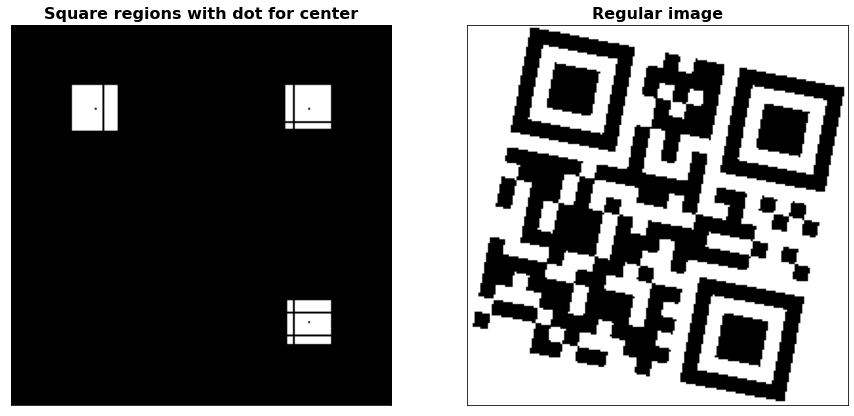

In [64]:
import sys 

def get_final_pts(final_pts: list, img_shape: tuple) -> list:
    """ 
    Must be in order (top left, top right, bottom left)
    """
    all_pts = copy.deepcopy(final_pts)
    one_to_two = np.array(final_pts[1]) - np.array(final_pts[0])
    if ((one_to_two + np.array(final_pts[2])) > img_shape).any():
        all_pts.append(tuple((np.array(final_pts[2]) - one_to_two).tolist()))
    else:
        all_pts.append(tuple((np.array(final_pts[2]) + one_to_two).tolist()))
    return all_pts


def get_all_possible_squares(img: list):
    final_zeros = np.zeros_like(img)
    zeros_dict = {}
    best_rot = None
    best_count = 0
    best_len = 0
    best_img = None
    zero_count = -10
    
    for rotation_x_10 in range(-150, 150, 1):
        rotation = rotation_x_10 / 10
#         print(f"On rotation {rotation}")
        sys.stdout.flush()
        if rotation == 0:
#             print("Reusing original")
            rot_img = copy.deepcopy(img)
#             rot_img_ex = ndimage.rotate(copy.deepcopy(img), rotation, reshape=False)
#             print((rot_img - rot_img_ex).sum())

#             print(rot_img)
            zeros = np.zeros_like(rot_img)
        else:
#             print("Rotating image")
            rot_img = np.round(ndimage.rotate(copy.deepcopy(img), rotation, reshape=False, cval=1.0))
#             print(rot_img[40:90, 40:90])
            zeros = np.zeros_like(rot_img)
        
        row_matches = get_potential_squares(rot_img, get_counts_bw(rot_img, axis=(0, 1)))
        column_matches = get_potential_squares(rot_img, get_counts_bw(rot_img, axis=(1, 0)), is_row=False)
        
        if not len(row_matches + column_matches):
#             print("No matchse")
            continue
            return rot_img, None, 2
        
        # find overlap between them
        ave_length = np.min([match[-1] for match in row_matches+column_matches])
        mid_points = defaultdict(int)
        
#         print(rotation, len(row_matches+column_matches))
        if best_count + 1 < len(row_matches+column_matches):
            best_rot = rotation
            best_count = len(row_matches+column_matches)
            best_len = ave_length
            best_img = rot_img
            
        if rotation == 0:
            zero_count = len(row_matches+column_matches)
            zero_len = ave_length
            zero_img = rot_img
    #     print("Row Matches\n", row_matches, "\n\nColumn Matches\n", column_matches)



        for match in row_matches:
    #         print(match)
            for i in range(match[-1]):
                zeros[match[0], match[1] + i] += 1

        for match in column_matches:
    #         print(match)
            for i in range(match[-1]):
                zeros[match[0] + i, match[1]] += 1
                
#         rot_zeros = np.round(ndimage.rotate(zeros, -1 * rotation, reshape=False, cval=0))
#         print(rot_zeros)
        zeros_dict[rotation] = zeros
#         final_zeros += zeros
            
#     return final_zeros, None, 0
    if best_count > zero_count + 10:
        final_zeros = zeros_dict[best_rot]
        ave_length = best_len
        print(f"Best rotation was {best_rot}")
    else:
        final_zeros = zeros_dict[0]
        ave_length = zero_len
        print("Best rotation was zero")
        
    pts_list = list(zip(*np.where(final_zeros > 1)))
#     print('buot to verify')
#     verify_points(img, pts_list)
    
#     return rot_img, None, None
    
#     print(pts_list)
    pts = np.array(pts_list)
    top_l = pts[pts.sum(axis=1).argmin()]
#     print("Topl", top_l)
    
    # find the bottom of it to get the length of the square
    points_on_left = pts[pts[:, 1] == top_l[1]]
    filter_again = points_on_left[points_on_left[:, 0] < top_l[0] + ave_length + 10]
    top_l_bottom_pt = filter_again[filter_again[:, 0].argmax()]
#     print(top_l_bottom_pt, "bottom left top")
    half_len = (top_l_bottom_pt[0] - top_l[0]) / 2
    
    right_max = pts[:, 1].max()
    all_right_pts = pts[pts[:, 1] == right_max]
    top_r = all_right_pts[all_right_pts[:, 0].argmin()]
    
    down_max = pts[:, 0].max()
    all_down_pts = pts[pts[:, 0] == down_max]
    bottom_l = all_down_pts[all_down_pts[:, 1].argmin()]
    
    # get the 6/10ths of the original length, then divide it by 2 to get half the square, then pythagorous formula to get
    # diagonal amount to travel
#     half_len = math.floor(np.sqrt(np.square(((ave_length / 10) * 3) / 2) * 2))
#     print(half_len, "is the half len")
    plus_or_minus_len = [-1 * half_len, half_len]
    
    final_mid_pts = []
    corner_pts = [top_l, top_r, bottom_l]
#     print(pts_list)
    for corner_pt in corner_pts:
#         print("On corner {}".format(corner_pt))
        for row_add in plus_or_minus_len:
            for col_add in plus_or_minus_len:
#                 print(corner_pt[0] + row_add, corner_pt[1] + col_add)
                to_check = round(corner_pt[0] + row_add), round(corner_pt[1] + col_add)
#                 print(row_add, col_add)
                if to_check in pts_list:
                    final_mid_pts.append(to_check)
                    break
                else:
                    pass #print(f"Didn't find {to_check}")
                
    if len(final_mid_pts) != 3:
        final_mid_pts = randomly_sample_points(img, pts)
#         print(f"## ERROR ONLY FOUND {final_mid_pts} ###")
#         return (final_zeros > 1).astype(float), final_mid_pts, ave_length, None
    
    end_zeros = np.zeros_like(final_zeros)
    dst_pts = get_final_pts(final_mid_pts, best_img.shape)
    for mid_pt in dst_pts:# + corner_pts:
        final_zeros[tuple(mid_pt)] = 0
        end_zeros[tuple(mid_pt)] = 5
                
    rot_zeros = np.round(ndimage.rotate(final_zeros, -1 * best_rot, reshape=False, cval=0))
    rot_pts = np.round(ndimage.rotate(end_zeros, -1 * best_rot, reshape=False, cval=1))
#     print(final_mid_pts)
#     print(rot_pts.max())
    final_new_pts = []
    while len(final_new_pts) != 4:
        argmax = unravel_index(rot_pts.argmax(), rot_pts.shape)
#        print(rot_pts.argmax())
        final_new_pts.append(argmax)
        rot_pts[argmax] = 0
        
    sorted_final_pts = []
    smallest = 100000
    smallest_pt = None
    largest_pt = None
    largest = 0
    for idx, pt in enumerate(final_new_pts):
        if pt[0] + pt[1] < smallest:
            smallest_pt = idx
            smallest = pt[0] + pt[1]
        if pt[0] + pt[1] > largest:
            largest_pt = pt
            largest = pt[0] + pt[1]
            
    sorted_final_pts.append(final_new_pts[smallest_pt])
#     print(largest_pt, final_new_pts[smallest_pt])
    del final_new_pts[smallest_pt]
    final_new_pts.remove(largest_pt)
    
    sorted(final_new_pts, key=lambda x: x[0])
    sorted_final_pts.extend(final_new_pts)
    sorted_final_pts.append(largest_pt)
    
#     print(sorted_final_pts)
#     print(dst_pts)

    return (final_zeros > 1).astype(float), (sorted_final_pts, dst_pts), ave_length, best_img

# TODO, do I need diangonals?
image = threshold_to_bw(cv2.imread("QR_codes/challenge1.png", cv2.IMREAD_GRAYSCALE))
# print(image)
zeros, final_pts, _, _ = get_all_possible_squares(image)
plt.subplot(121)
plt.imshow(zeros, cmap='gray')
just_title("Square regions with dot for center")
plt.subplot(122)
plt.imshow(image, cmap='gray')
just_title("Regular image")

### Part B: Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. If the warping present in the image is small enough, an affine transform is generally sufficient to find the fourth point (i.e. the *x,y* coordinate difference between point 1 and point 2 will be the same as the *x,y* coordinate difference between point 3 and point 4). Use this assumption to find the fourth point.

<div style="width:20%;text-align:center;"><img src="Images/four_points.JPG" width=100%></div>

Once you have the four points, generate the homography that would align the QR code with the *x,y* axes. Crop the aligned image until only the QR code is visible.

<div style="width:20%;text-align:center;"><img src="Images/aligned.jpg" width=100%></div>

Best rotation was zero


/mnt/c/Users/orion/Desktop/Fall 2020/CS450/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


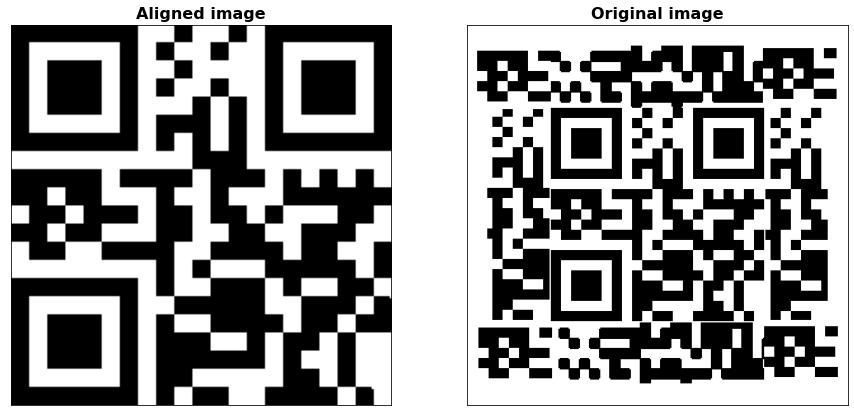

In [65]:
from itertools import combinations
import copy

def get_pts_for_ransac(final_pts: list) -> list:
    diff_x = (np.array(final_pts[1]) - np.array(final_pts[0]))[0]
    diff_y = (np.array(final_pts[2]) - np.array(final_pts[0]))[1]
    diff = np.array([diff_x, diff_y])
    print(f"Needs transformation of {diff}")
    dest = []
    for pt in final_pts:
        dest.append(tuple((np.array(pt) - diff).tolist()))
    return dest

def _get_slice_bbox(arr):
    nonzero = np.nonzero(arr)
    return [(min(a), max(a)+1) for a in nonzero]

def crop(arr):
    slice_bbox = _get_slice_bbox(arr)
    return arr[[slice(*a) for a in slice_bbox]]

def get_aligned_img(img):
    _, (src_pts, dst_pts), length, best_img = get_all_possible_squares(img)
#     length = math.ceil(length)
    length = round(length / 2)
#     all_pts = get_final_pts(final_pts)
#     print(f"All points are {all_pts}")
#     dst_pts = np.array(get_pts_for_ransac(all_pts))
#     print(dst_pts)
    dst_pts = np.array(dst_pts)
    src_pts = np.array(src_pts)
#     print(src_pts, "\n\n", dst_pts)
#     print(src_pts, dst_pts)
    cv_homography = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)[0]
#     print("\nThe Homography is\n", cv_homography)
    result_img = best_img
#     result_img = cv2.warpAffine(img, cv_homography, (img.shape[0], img.shape[1]))
    
    x_to_cut_off = dst_pts[0][0] - length
    y_to_cut_off = dst_pts[0][1] - length
#     print(length, x_to_cut_off, y_to_cut_off)
#     print(x_to_cut_off, y_to_cut_off, length)
    result_img = result_img[x_to_cut_off:-x_to_cut_off, y_to_cut_off:-y_to_cut_off]
    # do cropping
    result_img = 1 - crop(1 - result_img) # make black 1's so that we can crop zeros and then revert
    
    return result_img

image = threshold_to_bw(cv2.imread("QR_codes/challenge3.png", cv2.IMREAD_GRAYSCALE))
result_img = get_aligned_img(image)
# print(result_img)
plt.subplot(121)
plt.imshow(result_img, cmap='gray')
just_title("Aligned image")
plt.subplot(122)
plt.imshow(image, cmap='gray')
just_title("Original image")

### Part C: Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. The simplest way to do this is to count the number of black and white pixels in a region and assign the block to the highest count. However, to do this, the size of the QR code needs to be determined. All QR codes have an odd number of bits per row and column, starting at size 21 and incrementing by 4 (i.e. 21x21, 25x25, 29x29, ...). For this lab, you will only need to check for sizes from 21 to 33.

To check if a QR code matches a given size, discretize the QR code asumming the given size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size.

Once you have the correct size, discretize the QR code accordingly and return a Numpy array of True/False values.


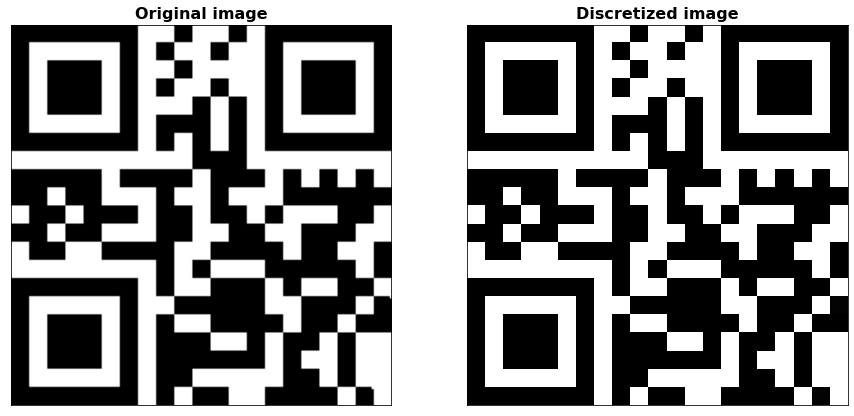

In [66]:
def discretize(img):
    possible_sizes = [21, 25, 29, 33]
    cur_shape = np.array(img.shape)
#     print(cur_shape)
    sizes_to_test = []
    for size in possible_sizes:
        new_shape = cur_shape / size
        if (new_shape != new_shape.astype(int)).all():
            pass #print(f"Didn't work for size {size}")
        else:
            sizes_to_test.append(size)
    
#     print(sizes_to_test)
    if not len(sizes_to_test):
        sizes_to_test = possible_sizes
    discretizations = []
    for size in sizes_to_test:
        discrete = np.zeros((size, size))
#         print(discrete)
        block = (cur_shape / size).astype(int)
        for x_idx in range(size):
             for y_idx in range(size):
#                 print(img[x_idx*block[0]:(x_idx+1)*block[0], y_idx*block[1]:(y_idx+1)*block[1]].sum())
                discrete[x_idx, y_idx] = img[x_idx*block[0]:(x_idx+1)*block[0], y_idx*block[1]:(y_idx+1)*block[1]].sum()
        discretizations.append(discrete)
                
    return discretizations

plt.subplot(121)
plt.imshow(result_img, cmap='gray')
just_title("Original image")

final_discrete = discretize(result_img)
plt.subplot(122)
plt.imshow(final_discrete[0], cmap='gray')
just_title("Discretized image")

### Part D: Decoding

QR codes are decoded using a very particular block pattern (see Understanding QR Codes). However, for simplicity, we have implemented this decoder for you. To use it, simply call `decode()` from the decoder.py file and feed it your 2D Numpy array. It will return a string with the QR code data.

**Note: You may need to run** `conda install beautifulsoup4` **and** `conda install requests` **to get the decoder to run.**

In [67]:
from decoder import decode
output = decode(final_discrete[0])
print(output)

http://byu.edu


In [68]:
# Put all the steps together into one function
def read_qr(img: np.array) -> np.array:
    img = threshold_to_bw(img)
    aligned_img = get_aligned_img(img)
    discrete = discretize(aligned_img)[0]
    output = decode(discrete)
#     for ind, discrete_ind in enumerate(discrete):
#         try:
#             output = decode(discrete_ind)
#             print(f"Worked for ind {ind}")
#             break
#         except Exception:
#             pass
    return aligned_img, output

# read_qr(img)

In [69]:
image = cv2.imread("QR_codes/test5.png", cv2.IMREAD_GRAYSCALE)
read_qr(image)[1]

Best rotation was zero


/mnt/c/Users/orion/Desktop/Fall 2020/CS450/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


'http://DataGenetics.com'

## Tests

Once you have your full algorithm working, run your code on the five test images in the *QR_codes* folder. Show your results below.

Best rotation was zero


/mnt/c/Users/orion/Desktop/Fall 2020/CS450/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Best rotation was 10.9
Best rotation was zero
Best rotation was zero
Best rotation was zero


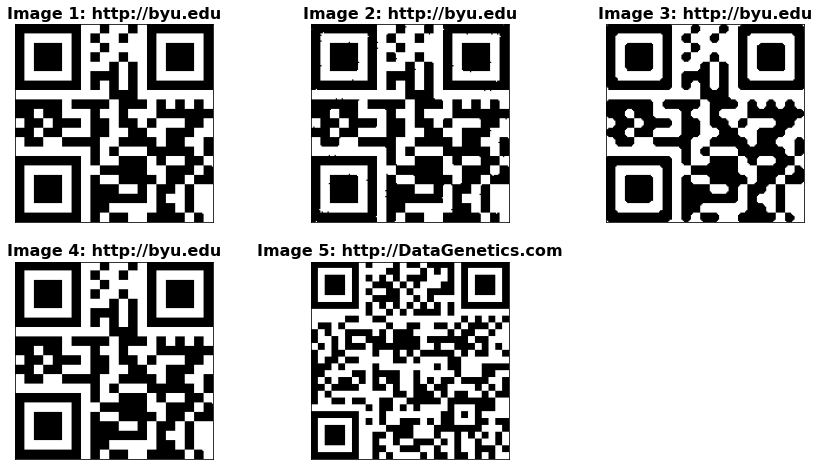

In [70]:
image = cv2.imread("QR_codes/test1.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(231)
new_img, output = read_qr(image)
plt.imshow(new_img, cmap="gray")
just_title(f"Image 1: {output}")

image = cv2.imread("QR_codes/test2.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(232)
new_img, output = read_qr(image)
plt.imshow(new_img, cmap="gray")
just_title(f"Image 2: {output}")

image = cv2.imread("QR_codes/test3.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(233)
new_img, output = read_qr(image)
plt.imshow(new_img, cmap="gray")
just_title(f"Image 3: {output}")

image = cv2.imread("QR_codes/test4.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(234)
new_img, output = read_qr(image)
plt.imshow(new_img, cmap="gray")
just_title(f"Image 4: {output}")

image = cv2.imread("QR_codes/test5.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(235)
new_img, output = read_qr(image)
plt.imshow(new_img, cmap="gray")
just_title(f"Image 5: {output}")


## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly finds the three corners of the QR code.
* [20 pts] Code that aligns the QR code and crops appropriately.
* [20 pts] Code that correctly discretizes for an arbitrary size.
* [10 pts] For a full algorithm that correctly scans the five test images.

The last 30 points are earned through completing a subset of the following challenges:

* [15 pts] Correctly scan a QR code that is misaligned by more than 90 degrees (e.g. challenge1.png)
* [15 pts] Correctly scan a QR code that is perspective shifted by using the additional alignment square present in larger QR codes. (e.g. challenge2.png)
* [15 pts] Correctly scan a QR code that is surrounded by additional pixels (e.g. challenge3.png)
* [15 pts] Correctly scan a QR code with large amounts of noise and distortion (e.g. challenge4.png)
* [30 pts] Implement a Code 128 1D bar code scanner (e.g. challenge5.png)

You may earn up to 15 points extra credit for additional challenges you complete.



Best rotation was 10.9


/mnt/c/Users/orion/Desktop/Fall 2020/CS450/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Best rotation was zero


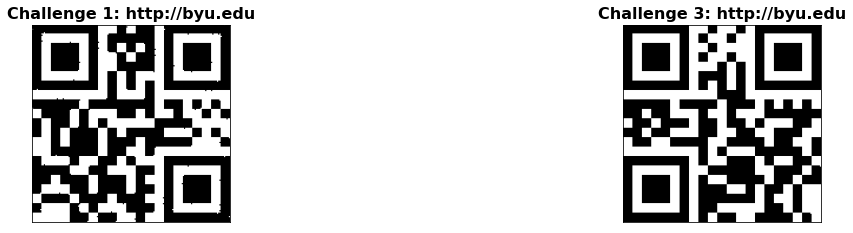

In [71]:
image = cv2.imread("QR_codes/challenge1.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(231)
new_img, output = read_qr(image)
plt.imshow(new_img,cmap="gray")
# plt.imshow(image,cmap="gray")
just_title(f"Challenge 1: {output}")

# image = cv2.imread("QR_codes/challenge2.png", cv2.IMREAD_GRAYSCALE)
# plt.subplot(232)
# new_img, output = read_qr(image)
# plt.imshow(new_img,cmap="gray")
# # plt.imshow(image,cmap="gray")
# just_title(f"Challenge 2: {output}")

image = cv2.imread("QR_codes/challenge3.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(233)
new_img, output = read_qr(image)
plt.imshow(new_img,cmap="gray")
# plt.imshow(image,cmap="gray")
just_title(f"Challenge 3: {output}")

# image = cv2.imread("QR_codes/challenge4.png", cv2.IMREAD_GRAYSCALE)
# plt.subplot(234)
# plt.imshow(read_qr(image)[0],cmap="gray")
# # plt.imshow(image,cmap="gray")
# just_title(f"Challenge 4: {read_qr(image)[1]}")

# image = cv2.imread("QR_codes/challenge5.png", cv2.IMREAD_GRAYSCALE)
# plt.subplot(235)
# plt.imshow(image,cmap="gray")
# just_title(f"Challenge 5")#: {read_qr(image)}")



## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* For each challenge completed, explain how you were able to solve the problem presented.
* What improvements would you recommend for this lab?


Your Write-up Here

1. I found the initial, finding the 1:1:3:1:1 to be the hardest.  It was hard to wrap my head around it conceptually.

2. For challenge 1, I was able to solve it by making my code able to find the fourth corner by using math to figure out the last point, making it invariant to which corners the initial three were in.  For challenge 3, I just used my regular algorithm, which included cropping, and it worked

3. I was interested in the 1D barcodes, but wasn't sure how to do it.  More information at the beginning of the lab would have been helpful (although not neccesary) :)